<a href="https://colab.research.google.com/github/lurich1/Diabetes/blob/main/PLANTDIEASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
import zipfile
import os

# Upload the dataset ZIP file
uploaded = files.upload()

# Extract the dataset
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')
print("Dataset extracted to 'dataset/'")


Saving dataset.zip to dataset.zip
Dataset extracted to 'dataset/'


In [4]:
import os
print(os.listdir("dataset/dataset"))


['test', 'train', 'valid']


In [5]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [6]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","dataset","train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","dataset","train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images

    def __len__(self):
        return len(self.labels)


    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [7]:
# Inherit from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [8]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)


    def forward(self,t):
        t = t

        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)


        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)


        t=self.fc2(t)
        t=F.relu(t)

        t=self.out(t)


        return t

In [9]:
model = Network()

In [10]:
dataset = Dataset()

{'Potato___Late_blight': 0, 'Tomato___Target_Spot': 1, 'Potato___Early_blight': 2, 'Tomato___Tomato_mosaic_virus': 3, 'Tomato___Early_blight': 4, 'Potato___healthy': 5, 'Tomato___Late_blight': 6, 'Cherry___Powdery_mildew': 7, 'Pepper___healthy': 8, 'Tomato___healthy': 9, 'Pepper___Bacterial_spot': 10, 'Tomato___Septoria_leaf_spot': 11, 'Tomato___Leaf_Mold': 12, 'Tomato___Spider_mites Two-spotted_spider_mite': 13, 'Cherry___healthy': 14, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 15, 'Tomato___Bacterial_spot': 16}


In [11]:
valdataset = ValDataset()

0 Potato___Late_blight
1 Tomato___Target_Spot
2 Potato___Early_blight
3 Tomato___Tomato_mosaic_virus
4 Tomato___Early_blight
5 Potato___healthy
6 Tomato___Late_blight
7 Cherry___Powdery_mildew
8 Pepper___healthy
9 Tomato___healthy
10 Pepper___Bacterial_spot
11 Tomato___Septoria_leaf_spot
12 Tomato___Leaf_Mold
13 Tomato___Spider_mites Two-spotted_spider_mite
14 Cherry___healthy
15 Tomato___Tomato_Yellow_Leaf_Curl_Virus
16 Tomato___Bacterial_spot


In [12]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' )
    plt.ylabel('loss ------>',color='m',fontsize='xx-large')
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 18 loss: 16.685229539871216
Epoch 1 total_correct 28 loss: 15.469670534133911
Epoch 2 total_correct 30 loss: 14.841571807861328
Epoch 3 total_correct 40 loss: 13.409436106681824
Epoch 4 total_correct 48 loss: 13.336099624633789
Epoch 5 total_correct 42 loss: 13.398293733596802
Epoch 6 total_correct 47 loss: 12.82592236995697
Epoch 7 total_correct 51 loss: 12.802054286003113
Epoch 8 total_correct 55 loss: 12.089770555496216
Epoch 9 total_correct 65 loss: 12.141031384468079
Epoch 10 total_correct 70 loss: 10.794649124145508
Epoch 11 total_correct 63 loss: 11.16620135307312
Epoch 12 total_correct 75 loss: 10.83771550655365
Epoch 13 total_correct 59 loss: 12.403367519378662
Epoch 14 total_correct 75 loss: 10.786003828048706
Epoch 15 total_correct 73 loss: 11.13280189037323
Epoch 16 total_correct 73 loss: 11.27438485622406
Epoch 17 total_correct 77 loss: 11.893721580505371
Epoch 18 total_correct 61 loss: 13.681892991065979
Epoch 19 total_correct 74 loss: 13.22615396976

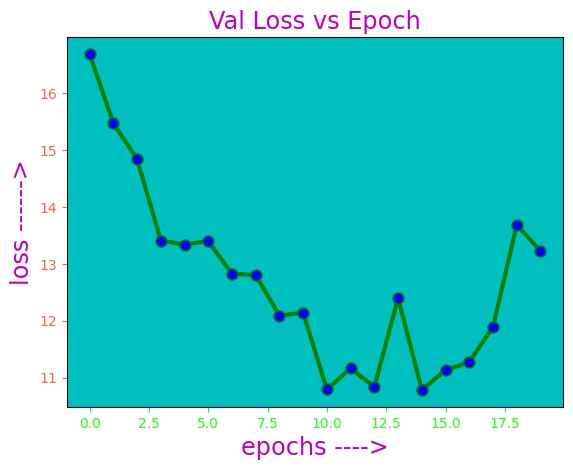

In [14]:
train(dataset,valdataset, model)

In [15]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("dataset","dataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [16]:
#Save the trained model
torch.save(model.state_dict(), "model.pth")

Class Distribution Histogram
To visualize the number of images per class in the training and validation **datasets** **bold text** **bold text**

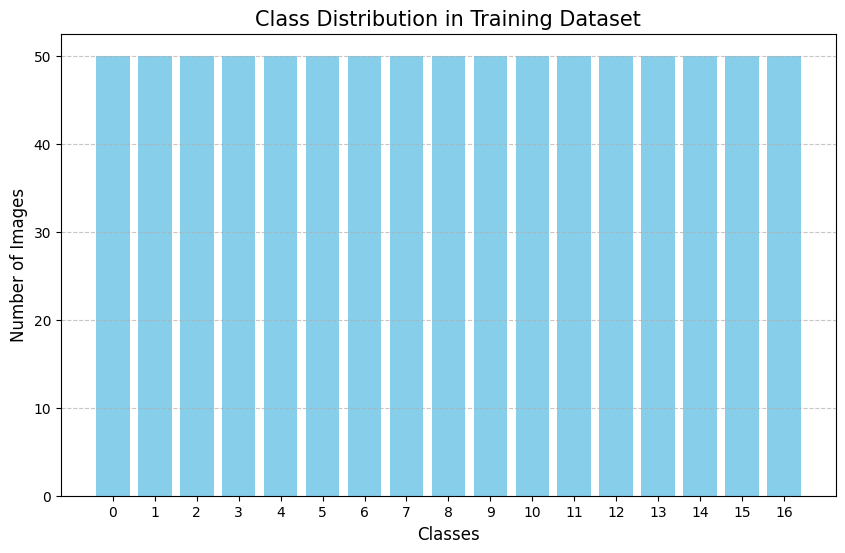

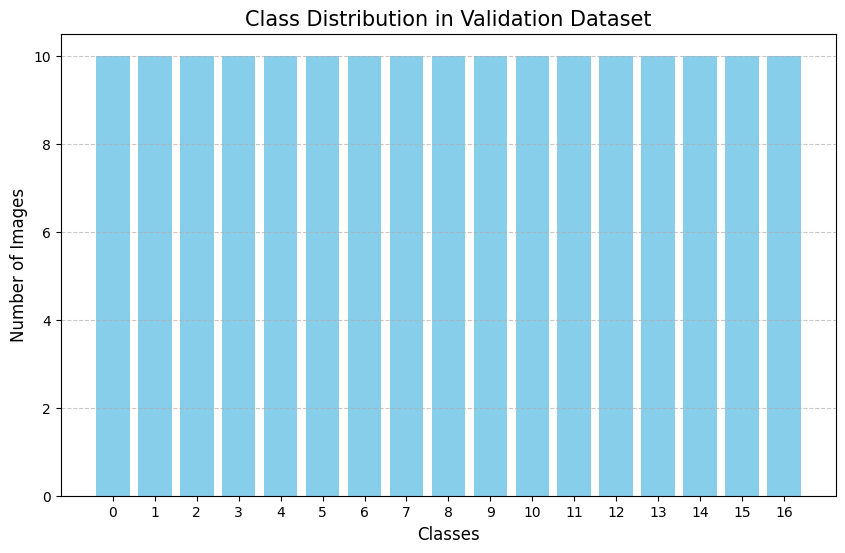

In [17]:
import matplotlib.pyplot as plt

def plot_class_distribution(labels, title):
    class_counts = {}
    for label in labels.values():
        class_counts[label] = class_counts.get(label, 0) + 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title(title, fontsize=15)
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot for training dataset
plot_class_distribution(dataset.labels, "Class Distribution in Training Dataset")

# Plot for validation dataset
plot_class_distribution(valdataset.labels, "Class Distribution in Validation Dataset")


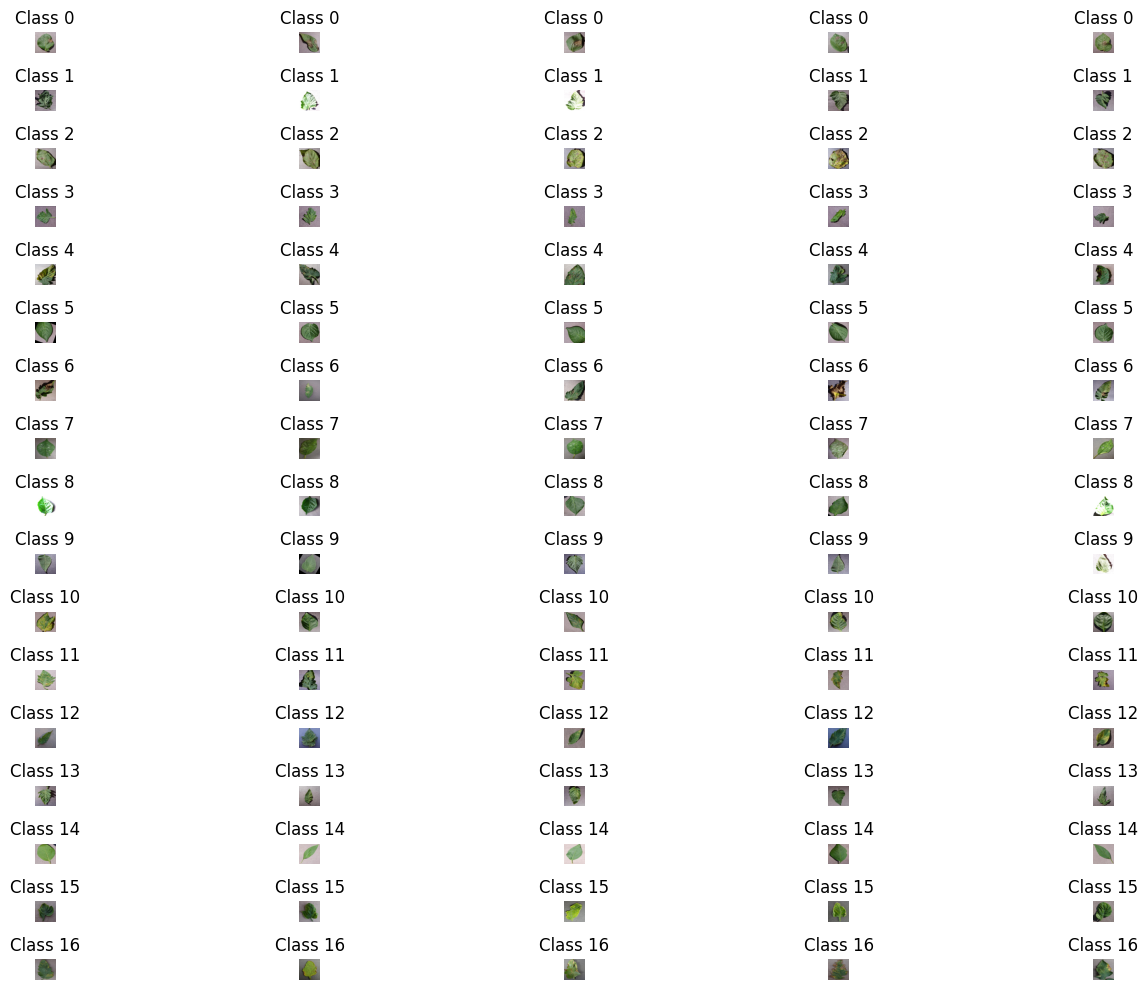

In [18]:
def visualize_images_per_class(images, labels, num_images=5):
    classes = set(labels.values())
    plt.figure(figsize=(15, 10))

    for i, cls in enumerate(classes):
        class_images = [idx for idx, label in labels.items() if label == cls][:num_images]
        for j, img_idx in enumerate(class_images):
            plt.subplot(len(classes), num_images, i * num_images + j + 1)
            plt.imshow(images[img_idx].permute(1, 2, 0))  # Convert to HxWxC
            plt.axis("off")
            plt.title(f"Class {cls}")

    plt.tight_layout()
    plt.show()

visualize_images_per_class(dataset.images, dataset.labels)


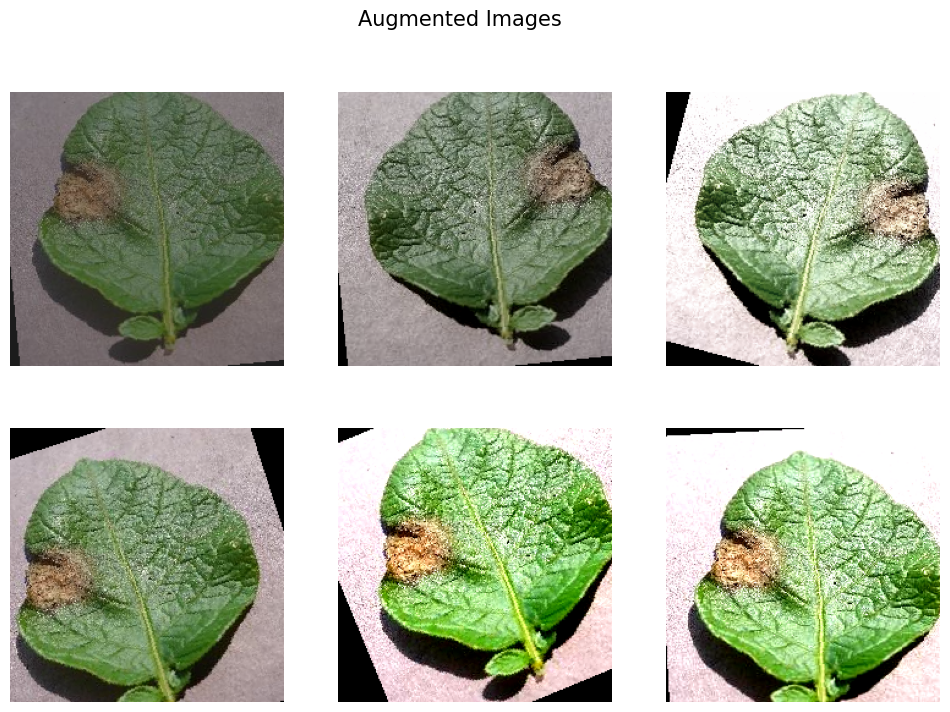

In [19]:
from torchvision import transforms

def visualize_augmentations(image):
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomCrop((224, 224)),
    ])

    plt.figure(figsize=(12, 8))
    for i in range(6):
        augmented_img = augmentations(image)
        plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_img.permute(1, 2, 0))
        plt.axis("off")

    plt.suptitle("Augmented Images", fontsize=15)
    plt.show()

# Visualize augmentations for a sample image
sample_image = dataset.images[0]  # Example image
visualize_augmentations(sample_image)


In [20]:
def plot_training_history(epochs, train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='orange')
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=15)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, num_classes):
    model.eval()
    y_true = []
    y_pred = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with max probability
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()


In [24]:
pip install scikit-learn


In [28]:
from torch.utils.data import DataLoader

# Assuming `valdataset` is an instance of the ValDataset class
valdataset = ValDataset()
valdataloader = DataLoader(valdataset, batch_size=32, shuffle=False)
from torch.utils.data import DataLoader

# Assuming `valdataset` is an instance of the ValDataset class
valdataset = ValDataset()
valdataloader = DataLoader(valdataset, batch_size=32, shuffle=False)


0 Potato___Late_blight
1 Tomato___Target_Spot
2 Potato___Early_blight
3 Tomato___Tomato_mosaic_virus
4 Tomato___Early_blight
5 Potato___healthy
6 Tomato___Late_blight
7 Cherry___Powdery_mildew
8 Pepper___healthy
9 Tomato___healthy
10 Pepper___Bacterial_spot
11 Tomato___Septoria_leaf_spot
12 Tomato___Leaf_Mold
13 Tomato___Spider_mites Two-spotted_spider_mite
14 Cherry___healthy
15 Tomato___Tomato_Yellow_Leaf_Curl_Virus
16 Tomato___Bacterial_spot
0 Potato___Late_blight
1 Tomato___Target_Spot
2 Potato___Early_blight
3 Tomato___Tomato_mosaic_virus
4 Tomato___Early_blight
5 Potato___healthy
6 Tomato___Late_blight
7 Cherry___Powdery_mildew
8 Pepper___healthy
9 Tomato___healthy
10 Pepper___Bacterial_spot
11 Tomato___Septoria_leaf_spot
12 Tomato___Leaf_Mold
13 Tomato___Spider_mites Two-spotted_spider_mite
14 Cherry___healthy
15 Tomato___Tomato_Yellow_Leaf_Curl_Virus
16 Tomato___Bacterial_spot


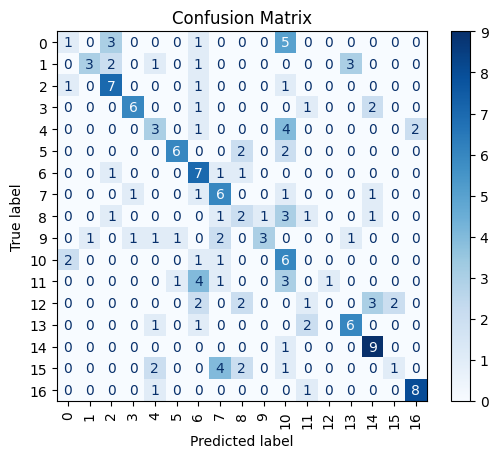

In [29]:
plot_confusion_matrix(model, valdataloader, num_classes=17)


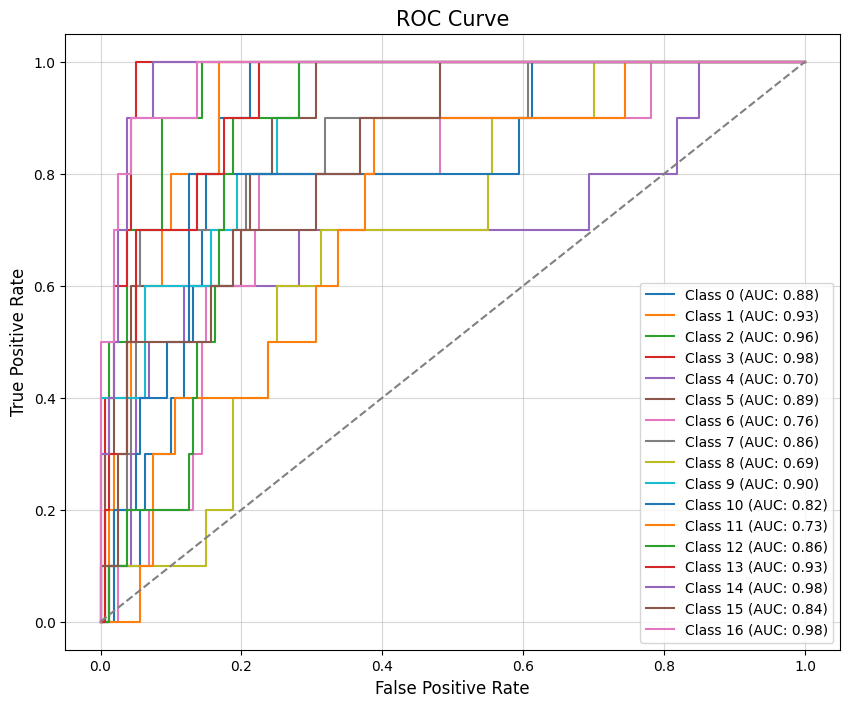

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, dataloader, num_classes):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            all_preds.extend(outputs.numpy())
            all_labels.extend(labels.numpy())

    all_labels = label_binarize(all_labels, classes=range(num_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], [pred[i] for pred in all_preds])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC: {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve", fontsize=15)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Use validation dataloader
plot_roc_curve(model, valdataloader, num_classes=17)


In [48]:
import torch
from PIL import Image
from torchvision import transforms
import os

# Dummy reference dictionary for class mapping (you should replace this with actual class names)
reference = {
    0: 'Class_1',
    1: 'Class_2',
    2: 'Class_3',

}

# Define your model (Replace with your actual model)
model = torch.load('model002_ep20.pth', weights_only=True)  # Load your trained model here

# Updated predict function with direct file path input
def predict(img_path):
    if not img_path:
        print("No image selected.")
        return

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")

    # Define the transforms to resize the image and convert to tensor
    resize = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    input_tensor = resize(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    model.eval()
    with torch.no_grad():
        y_result = model(input_tensor)
        result_idx = y_result.argmax(dim=1).item()

    # Map the index to a class label
    predicted_class = reference.get(result_idx, "Unknown class")

    # Display the class for the image
    print(f"Image: {os.path.basename(img_path)} - Predicted Class: {predicted_class}")


# Path to the directory containing images
img_dir = 'dataset/dataset/train/Tomato___healthy/'

# Loop through all image files in the directory
for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)

    # Check if the file is an image
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        predict(img_path)


In [49]:
results = []

# Loop through all image files in the directory
for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)

    # Check if the file is an image
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        predicted_class = predict(img_path)
        results.append((img_file, predicted_class))

# Optionally print the collected results
for img_file, predicted_class in results:
    print(f"Image: {img_file} - Predicted Class: {predicted_class}")
